In [1]:
import pylab as py
import numpy as np
import random as rn
import time
import scipy.special.cython_special
%run Jackknife.ipynb
pi = np.pi

In [2]:
def dh4(f,x):
    '''
    4th order numerical derivative.
    '''
    f_prima = np.zeros(len(f))
    h = (x[1] - x[0]) 
    h_12 = 12*h
    for i in range(2,len(f)-2):
            f_prima[i] = ( -f[i+2] + 8 * (f[i+1]-f[i-1]) + f[i-2])/(h_12) 
    c0,c1,c2,c3,c4 = -25/12, 4, -3, 4/3, -0.25
    f_prima[0] = (c0*f[0] + c1*f[1] + c2*f[2] + c3*f[3]+c4*f[4])/h
    f_prima[1] = (c0*f[1] + c1*f[2] + c2*f[3] + c3*f[4]+c4*f[5])/h
    f_prima[-1] = -(c0*f[-1] + c1*f[-2] + c2*f[-3] + c3*f[-4]+c4*f[-5])/h
    f_prima[-2] = -(c0*f[-2] + c1*f[-3] + c2*f[-4] + c3*f[-5]+c4*f[-6])/h
                         
    return f_prima

def TotalFlux(Coords,FluxX, FluxY):
    return (FluxX[Coords[0],Coords[1]] - FluxX[Coords[0],(Coords[1]-1)%L] + FluxY[Coords[0],Coords[1]] - FluxY[(Coords[0]-1)%L,Coords[1]])

def TotalFluxMatrix(L,FluxX,FluxY):
    Flux = np.zeros((L,L))
    for i in range(L):
        for j in range(L):
            Flux[i,j] = TotalFlux([i,j],FluxX,FluxY)
    return Flux

def Energy(L,beta,FluxX, FluxY):
    En = 0
    for i in range(L):
        for j in range(L):
            En += scipy.special.ivp(FluxX[i,j], beta, n=1)/scipy.special.iv(FluxX[i,j], beta, out=None) +\
            scipy.special.ivp(FluxY[i,j], beta, n=1)/scipy.special.iv(FluxY[i,j], beta, out=None)
    return -En
            
def AccRatio(mu,beta,L,Masha,FluxX, FluxY):
    if mu == 0:
        FluxIni = FluxX[Masha[0],Masha[1]]
    elif mu == 1:
        FluxIni = -FluxX[Masha[0],(Masha[1]-1)%L]
    elif mu == 2:
        FluxIni = - FluxY[(Masha[0]-1)%L,Masha[1]]
    elif mu == 3:
        FluxIni = FluxY[Masha[0],Masha[1]]
    FluxFin = FluxIni + 1
        
    R = scipy.special.iv(FluxFin, beta, out=None)/scipy.special.iv(FluxIni, beta, out=None)          
    return R
            
def WA_sweep(L,beta,FluxX, FluxY, Masha):   
    mu = rn.randint(0, 3) #0 --> +x direction, 1 --> -x direction, 2 --> +y direction, 3 --> -y direction
    R = AccRatio(mu,beta,L,Masha,FluxX, FluxY)
    r = rn.random() #random number between zero and one  
    if r < R:
        if mu == 0: 
            FluxX[Masha[0], Masha[1]] += 1   #Create bond from Masha to the right site -->
            Masha[1] = (Masha[1]+1) % L #move masha one site to the right           
        elif mu == 1: 
            FluxX[Masha[0],(Masha[1]-1) % L] -= 1  #Create bond from Masha to the left site <--
            Masha[1] = (Masha[1]-1) % L #move masha one site to the left    
        elif mu == 2: 
            FluxY[(Masha[0]-1)%L, Masha[1]] -= 1 #Create bond from Masha to the site above         
            Masha[0] = (Masha[0]-1) % L #move masha up   
        elif mu == 3: 
            FluxY[Masha[0], Masha[1]] += 1 #Create bond from Masha to the site below
            Masha[0] = (Masha[0]+1) % L #move masha dowm
    #print('mu',mu)
    return Masha, FluxX, FluxY

def WA_XY2d(beta,L,Ntherm,Nmeas,Nsteps):
    Ira = [rn.randint(0, L-1), rn.randint(0,L-1)] #randint(a,b) generates a random number r\in[a,b] (closed interval)
    Masha = [Ira[0],Ira[1]]
    FluxX, FluxY = np.zeros((L,L)), np.zeros((L,L))
    G = np.zeros(L**2)
    Chi = []
    En = []
    #----Thermalization steps----#
    for i in range(Ntherm):
        if Masha == Ira: 
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]]
        Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
    #---------------------------#
    count = 0
    #----Measurements----#
    while count<Nmeas:
        SiteIra = Ira[1] + Ira[0]*L
        SiteMasha = Masha[1] + Masha[0]*L
        G[abs(SiteIra-SiteMasha)] += 1
        if Masha == Ira:
            En.append(Energy(L,beta,FluxX, FluxY))
            count += 1
            Chi.append(np.sum(G)/G[0])
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]] 
        Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
    #----Decorrelation steps----#
        for j in range(Nsteps): 
            SiteIra = Ira[1] + Ira[0]*L
            SiteMasha = Masha[1] + Masha[0]*L
            G[abs(SiteIra-SiteMasha)] += 1
            if Masha == Ira:
                Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
                Masha = [Ira[0],Ira[1]]
            Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
    En = np.array(En)
    E = np.mean(En)
    dE = Jerr(En)
    Chi = np.array(Chi)
    chi = np.mean(Chi)
    dchi = Jerr(Chi) 
    return chi, dchi, E, dE

def ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_in,beta_fin,beta_step):
    beta = np.linspace(beta_in,beta_fin,beta_step)
    Chi, dChi = [], []
    En, dEn = [], []
    for i in range(len(beta)):
        chi, dchi, E, dE  = WA_XY2d(beta[i],L,Ntherm,Nmeas,Nsteps)
        Chi.append(chi)
        dChi.append(dchi)
        En.append(E)
        dEn.append(dE)
        print('i',i,'beta',beta[i],'T',1/beta[i])
        print('chi',chi,'+-',dchi)
        print('Energy',E,'+-',dE)
        print('---------------------------')
    dChi = np.array(dChi)
    Chi = np.array(Chi)
    En = np.array(En)
    dEn = np.array(dEn)
    return Chi, dChi, En, dEn 

In [3]:
Ntherm, Nmeas, Nsteps = 1000, 1000, 10
beta_ini, beta_fin, beta_step = 0.1, 1.4, 30
beta = np.linspace(beta_ini,beta_fin,beta_step)

L = 8
print('L={0}'.format(L))
Chi8, dChi8, E8, dE8 = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)
Cv8 = -beta**2*dh4(E8,beta)
dCv8 = -beta**2*dh4(dE8,beta)

L = 10
print('L={0}'.format(L))
Chi10, dChi10, E10, dE10  = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)
Cv10 = -beta**2*dh4(E10,beta)
dCv10 = -beta**2*dh4(dE10,beta)
L = 16
print('L={0}'.format(L))
Chi16, dChi16, E16, dE16  = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)
Cv16 = -beta**2*dh4(E16,beta)
dCv16 = -beta**2*dh4(dE16,beta)
L = 24
print('L={0}'.format(L))
Chi24, dChi24, E24, dE24  = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)
Cv24 = -beta**2*dh4(E24,beta)
dCv24 = -beta**2*dh4(dE24,beta)

L=8
i 0 beta 0.1 T 10.0
chi 1.2188830293386068 +- 0.007745654581617023
Energy -6.392013310456192 +- 3.958239547203054e-12
---------------------------
i 1 beta 0.14482758620689656 T 6.904761904761904
chi 1.3468369330430576 +- 0.02333972230641912
Energy -9.244748064889006 +- 5.053071762386877e-13
---------------------------
i 2 beta 0.1896551724137931 T 5.272727272727273
chi 1.5731497899886626 +- 0.01681439052359357
Energy -12.418125052033522 +- 0.29263731822141104
---------------------------
i 3 beta 0.23448275862068965 T 4.264705882352941
chi 1.7024859277969935 +- 0.010669789517153477
Energy -15.258060866413832 +- 0.20551220388699468
---------------------------
i 4 beta 0.2793103448275862 T 3.580246913580247
chi 1.9842939300209173 +- 0.025341509614386748
Energy -18.60273082947161 +- 0.36535425822460893
---------------------------
i 5 beta 0.32413793103448274 T 3.0851063829787235
chi 2.207682966311433 +- 0.02221858010585057
Energy -21.426904671191807 +- 0.3142429369666909
--------------

i 19 beta 0.9517241379310343 T 1.0507246376811596
chi 43.521511156133734 +- 1.00034897818756
Energy -129.26236906724534 +- 0.8189134915892282
---------------------------
i 20 beta 0.9965517241379308 T 1.003460207612457
chi 51.37733885768827 +- 0.5804371518828628
Energy -134.22981679250006 +- 0.7864392446679048
---------------------------
i 21 beta 1.0413793103448274 T 0.9602649006622518
chi 54.84523080338296 +- 1.094659377003989
Energy -139.44612212139464 +- 0.6408525639277229
---------------------------
i 22 beta 1.086206896551724 T 0.9206349206349208
chi 57.776798686541255 +- 1.3048811241591203
Energy -142.59243390827118 +- 0.8684047651501522
---------------------------
i 23 beta 1.1310344827586205 T 0.8841463414634148
chi 54.69857999456814 +- 1.2467831818870323
Energy -146.05755743950067 +- 0.4576045869719295
---------------------------
i 24 beta 1.1758620689655173 T 0.8504398826979472
chi 59.90746190665072 +- 1.3006755340102778
Energy -148.8811986652919 +- 0.4840426207398423
------

i 8 beta 0.45862068965517233 T 2.1804511278195493
chi 3.521237314909213 +- 0.12258451148624619
Energy -282.83278818162484 +- 4.803058916341882
---------------------------
i 9 beta 0.5034482758620689 T 1.986301369863014
chi 4.146270725551218 +- 0.12922243243479867
Energy -318.3989572044838 +- 4.890166112481511
---------------------------
i 10 beta 0.5482758620689654 T 1.8238993710691829
chi 4.906941704544291 +- 0.08097047376914367
Energy -351.89910066289326 +- 4.557105877586775
---------------------------
i 11 beta 0.593103448275862 T 1.686046511627907
chi 5.600454768500191 +- 0.40345446038806854
Energy -383.65889002857085 +- 9.909905338488306
---------------------------
i 12 beta 0.6379310344827586 T 1.5675675675675678
chi 8.901232105670342 +- 0.8041246806963409
Energy -421.299951432365 +- 4.8286829361508765
---------------------------
i 13 beta 0.6827586206896551 T 1.4646464646464648
chi 9.70061620070337 +- 0.4097988338033405
Energy -454.0715760139873 +- 6.6602658177777485
-----------

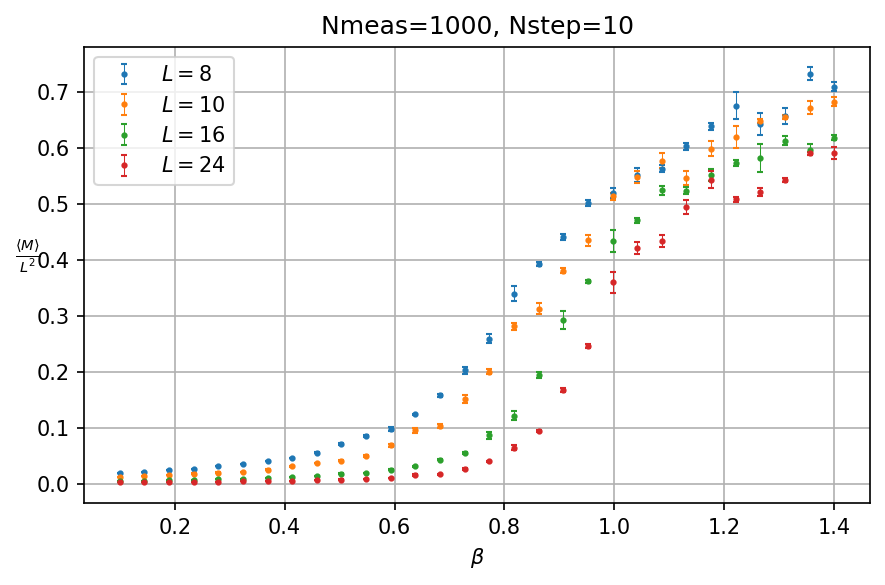

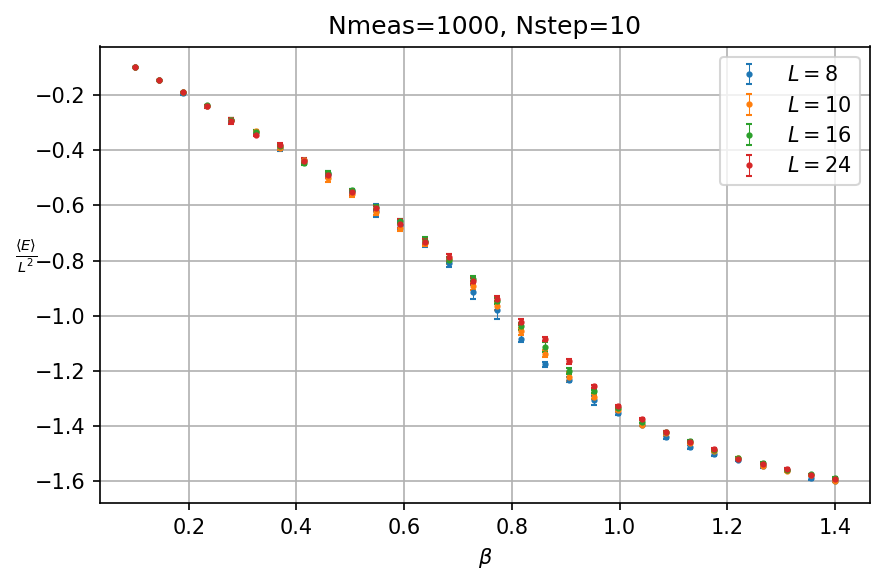

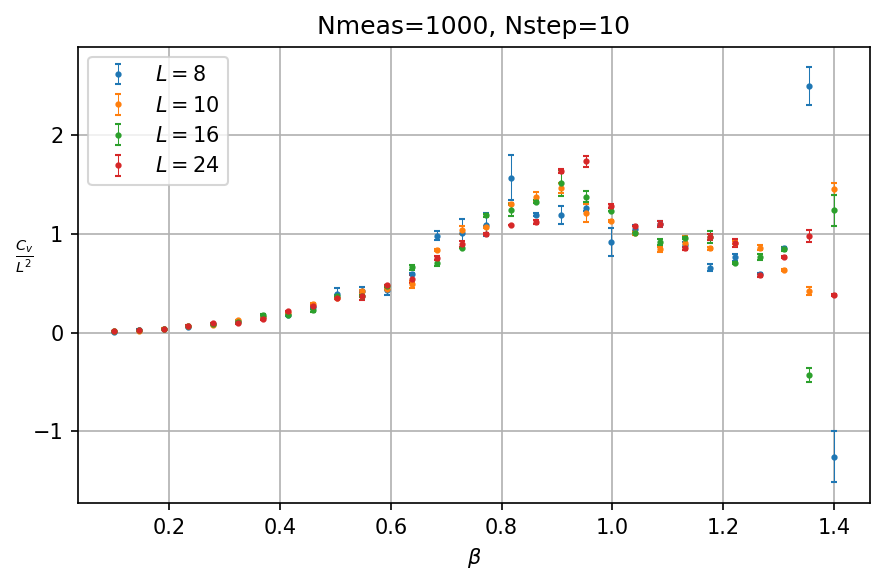

In [4]:
fig = py.figure(dpi=150)
py.errorbar(beta,Chi8/8**2,yerr=dChi8/8**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(8))
py.errorbar(beta,Chi10/10**2,yerr=dChi10/10**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(10))
py.errorbar(beta,Chi16/16**2,yerr=dChi16/16**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(16))
py.errorbar(beta,Chi24/24**2,yerr=dChi24/24**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(24))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\langle M \rangle}{L^2}$',rotation=0)
py.legend()
py.grid()
#py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
fig.savefig('2DXYMagDenAllL.pdf')
py.show()

fig = py.figure(dpi=150)
beta = np.linspace(beta_ini,beta_fin,beta_step)
py.errorbar(beta,E8/8**2,yerr=dE8/8**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(8))
py.errorbar(beta,E10/10**2,yerr=dE10/10**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(10))
py.errorbar(beta,E16/16**2,yerr=dE16/16**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(16))
py.errorbar(beta,E24/24**2,yerr=dE24/24**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(24))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\langle E \rangle}{L^2}$',rotation=0)
py.legend()
py.grid()
#py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
fig.savefig('2DXYEnAllL.pdf')
py.show()

fig = py.figure(dpi=150)
beta = np.linspace(beta_ini,beta_fin,beta_step)
py.errorbar(beta,Cv8/8**2,yerr=dCv8/8**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(8))
py.errorbar(beta,Cv10/10**2,yerr=dCv10/10**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(10))
py.errorbar(beta,Cv16/16**2,yerr=dCv16/16**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(16))
py.errorbar(beta,Cv24/24**2,yerr=dCv24/24**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(24))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{C_v}{L^2}$',rotation=0)
py.legend()
py.grid()
#py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
fig.savefig('2DXYCvAllL.pdf')
py.show()

# Debug

This part is to debug the code.

In [ ]:
def dh4(f,x):
    f_prima = np.zeros(len(f))
    h = (x[1] - x[0]) 
    h_12 = 12*h
    for i in range(2,len(f)-2):
        #Para todos los puntos que están en el intervalo [2,N-2] de la malla con N puntos, el algoritmo es el siguiente
            f_prima[i] = ( -f[i+2] + 8 * (f[i+1]-f[i-1]) + f[i-2])/(h_12) 
        #Para los puntos externos al intervalo [2,N-2] aplicamos las ecuaciones () y () 
    c0,c1,c2,c3,c4 = -25/12, 4, -3, 4/3, -0.25
    #Derivada en el primer punto de l a malla
    f_prima[0] = (c0*f[0] + c1*f[1] + c2*f[2] + c3*f[3]+c4*f[4])/h
           #derivada en el segundo punto
    f_prima[1] = (c0*f[1] + c1*f[2] + c2*f[3] + c3*f[4]+c4*f[5])/h
            #derivada en el último punto
    f_prima[-1] = -(c0*f[-1] + c1*f[-2] + c2*f[-3] + c3*f[-4]+c4*f[-5])/h
           #derivada en el penúltimo punto
    f_prima[-2] = -(c0*f[-2] + c1*f[-3] + c2*f[-4] + c3*f[-5]+c4*f[-6])/h
                         
    return f_prima

def TotalFlux(Coords,FluxX, FluxY):
    return (FluxX[Coords[0],Coords[1]] - FluxX[Coords[0],(Coords[1]-1)%L] + FluxY[Coords[0],Coords[1]] - FluxY[(Coords[0]-1)%L,Coords[1]])

def TotalFluxMatrix(L,FluxX,FluxY):
    Flux = np.zeros((L,L))
    for i in range(L):
        for j in range(L):
            Flux[i,j] = TotalFlux([i,j],FluxX,FluxY)
    return Flux

def Energy(L,beta,FluxX, FluxY):
    En = 0
    for i in range(L):
        for j in range(L):
            En += scipy.special.ivp(FluxX[i,j], beta, n=1)/scipy.special.iv(FluxX[i,j], beta, out=None) +\
            scipy.special.ivp(FluxY[i,j], beta, n=1)/scipy.special.iv(FluxY[i,j], beta, out=None)
    return -En
            
def AccRatio(mu,beta,L,Masha,FluxX, FluxY):
    if mu == 0:
        FluxIni = FluxX[Masha[0],Masha[1]]
        n = 1
    elif mu == 1:
        #FluxIni = -FluxX[Masha[0],(Masha[1]-1)%L]
        FluxIni = FluxX[Masha[0],(Masha[1]-1)%L]
        n = -1
    elif mu == 2:
        #FluxIni = - FluxY[(Masha[0]-1)%L,Masha[1]]
        FluxIni =  FluxY[(Masha[0]-1)%L,Masha[1]]
        n = -1
    elif mu == 3:
        n = 1
        FluxIni = FluxY[Masha[0],Masha[1]]
    FluxFin = FluxIni + n 
        
    R = scipy.special.iv(FluxFin, beta, out=None)/scipy.special.iv(FluxIni, beta, out=None)          
    return R
            
def WA_sweep(L,beta,FluxX, FluxY, Masha):   
    mu = rn.randint(0, 3) #0 --> +x direction, 1 --> -x direction, 2 --> +y direction, 3 --> -y direction
    R = AccRatio(mu,beta,L,Masha,FluxX, FluxY)
    r = rn.random() #random number between zero and one  
    if r < R:
        if mu == 0: 
            FluxX[Masha[0], Masha[1]] += 1   #Create bond from Masha to the right site -->
            Masha[1] = (Masha[1]+1) % L #move masha one site to the right           
        elif mu == 1: 
            FluxX[Masha[0],(Masha[1]-1) % L] -= 1  #Create bond from Masha to the left site <--
            Masha[1] = (Masha[1]-1) % L #move masha one site to the left    
        elif mu == 2: 
            FluxY[(Masha[0]-1)%L, Masha[1]] -= 1 #Create bond from Masha to the site above         
            Masha[0] = (Masha[0]-1) % L #move masha up   
        elif mu == 3: 
            FluxY[Masha[0], Masha[1]] += 1 #Create bond from Masha to the site below
            Masha[0] = (Masha[0]+1) % L #move masha dowm
    #print('mu',mu)
    return Masha, FluxX, FluxY

def WA_XY2dDebug(beta,L,Ntherm,Nmeas,Nsteps):
    Ira = [rn.randint(0, L-1), rn.randint(0,L-1)] #randint(a,b) generates a random number r\in[a,b] (closed interval)
    Masha = [Ira[0],Ira[1]]
    FluxX, FluxY = np.zeros((L,L)), np.zeros((L,L))

    tau = 0.0
    TAU = []
    z = 0
    print('INICIO')
    print('    Ira',Ira,'    Masha',Masha)
    print('z',z)
    print('FluxX (right direction)',FluxX)
    print('FluxY (down direction)',FluxY)
    print('TotalFlux',TotalFluxMatrix(L,FluxX,FluxY))
    print('----------------------------------------')
    for i in range(Ntherm):   
        if Masha == Ira: 
            z += 1
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]]
        Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
        print('i',i,'    Ira',Ira,'    Masha',Masha)
        print('z',z)
        print('FluxX (right direction)',FluxX)
        print('FluxY (down direction)',FluxY)
        print('TotalFlux',TotalFluxMatrix(L,FluxX,FluxY))
        print('----------------------------------------')
    return 0, 0

def WA_XY2d(beta,L,Ntherm,Nmeas,Nsteps):
    Ira = [rn.randint(0, L-1), rn.randint(0,L-1)] #randint(a,b) generates a random number r\in[a,b] (closed interval)
    Masha = [Ira[0],Ira[1]]
    FluxX, FluxY = np.zeros((L,L)), np.zeros((L,L))
    G = np.zeros(L**2)
    Chi = []
    En = []
    #----Thermalization steps----#
    for i in range(Ntherm):
        if Masha == Ira: 
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]]
        Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
    #---------------------------#
    count = 0
    while count<Nmeas:
        SiteIra = Ira[1] + Ira[0]*L
        SiteMasha = Masha[1] + Masha[0]*L
        G[abs(SiteIra-SiteMasha)] += 1
        if Masha == Ira:
            En.append(Energy(L,beta,FluxX, FluxY))
            count += 1
            Chi.append(np.sum(G)/G[0])
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]] 
        Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
        for j in range(Nsteps): 
            SiteIra = Ira[1] + Ira[0]*L
            SiteMasha = Masha[1] + Masha[0]*L
            G[abs(SiteIra-SiteMasha)] += 1
            if Masha == Ira:
                Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
                Masha = [Ira[0],Ira[1]]
            Masha, FluxX, FluxY = WA_sweep(L,beta,FluxX, FluxY,Masha)
    En = np.array(En)
    E = np.mean(En)
    dE = Jerr(En,20)
    Chi = np.array(Chi)
    chi = np.mean(Chi)
    dchi = Jerr(Chi,20) 
    return chi, dchi, E, dE

def ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_in,beta_fin,beta_step):
    beta = np.linspace(beta_in,beta_fin,beta_step)
    Chi, dChi = [], []
    En, dEn = [], []
    for i in range(len(beta)):
        chi, dchi, E, dE  = WA_XY2d(beta[i],L,Ntherm,Nmeas,Nsteps)
        Chi.append(chi)
        dChi.append(dchi)
        En.append(E)
        dEn.append(dE)
        print('i',i,'beta',beta[i],'T',1/beta[i])
        print('chi',chi,'+-',dchi)
        print('Energy',E,'+-',dE)
        print('---------------------------')
    dChi = np.array(dChi)
    Chi = np.array(Chi)
    En = np.array(En)
    dEn = np.array(dEn)
    return Chi, dChi, En, dEn 

In [ ]:
Ntherm, Nmeas, Nsteps = 100000, 1000, 10
beta_ini, beta_fin, beta_step = 0.1, 1.4, 30
beta = np.linspace(beta_ini,beta_fin,beta_step)
L = 10
print('L={0}'.format(L))
Chi, dChi, E, dE = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)
Cv = -beta**2*dh4(E,beta)
dCv = -beta**2*dh4(dE,beta)

In [ ]:
beta = np.linspace(beta_ini,beta_fin,beta_step)
fig = py.figure(dpi=150)
py.errorbar(beta,Chi/L**2,yerr=dChi/L**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\langle M^2 \rangle}{L^2}$',rotation=0)
py.legend()
py.grid()
py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
py.show()

fig = py.figure(dpi=150)
py.errorbar(beta,E/L**2,yerr=dE/L**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\langle E\rangle}{L^2}$',rotation=0)
py.legend()
py.grid()
py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
py.show()

fig = py.figure(dpi=150)
py.errorbar(beta,Cv/L**2,yerr=dCv/L**2,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{C_V}{L^2}$',rotation=0)
py.legend()
py.grid()
py.xlim([0,1.41])
#py.ylim([0,0.9])
py.tight_layout()
py.show()